## Step 3, Analyst data
* Read csv file, main_customers.csv
* Explore data

In [58]:
%matplotlib inline

In [59]:
### import all the dependencies 
import requests
import csv
import json
import pandas as pd
import re
import matplotlib.pyplot as plt
from datetime import datetime
import numpy as np
import os
from palettable.colorbrewer.qualitative import Pastel1_7  # Inferno_4,Plasma_5,Viridis_6,Viridis_4 
import warnings
import configparser
warnings.filterwarnings('ignore')

In [60]:
# Define all variables 
configFile = "config.cfg"
config = configparser.ConfigParser()
config.read(configFile)

['config.cfg']

### Extract data from csv file 

In [61]:
external_customers_df = pd.read_csv("data/external_customers.csv", low_memory=False)
print('Shape of exports read from CSV : {}'.format(external_customers_df.shape))

Shape of exports read from CSV : (78291, 15)


In [62]:
external_customers_df.columns

Index(['Domain', 'UserEmail', 'serviceName', 'UserId', 'IndvId', 'SessionId',
       'PageUrl', 'PageRefererUrl', 'PageBrowser', 'PageDevice',
       'PageDuration', 'PageActiveDuration', 'PageLatLong', 'EventStart',
       'EventType'],
      dtype='object')

In [63]:
len(external_customers_df.columns)

15

In [64]:
external_customers_df.head()   

,Domain,UserEmail,serviceName,UserId,IndvId,SessionId,PageUrl,PageRefererUrl,PageBrowser,PageDevice,PageDuration,PageActiveDuration,PageLatLong,EventStart,EventType
0,Company1.com,chad.tew@Company1.com,Data Logging,5650932471693312,5650932471693312,5629499534213120,https://www.cloud.dataguru.com/li/,https://console.cloud.dataguru.com/bin/gateway...,Chrome,Desktop,20030,3459,"33.3335,-86.9591",2018-09-08T23:10:55.257Z,navigate
1,Company1.com,chad.tew@Company1.com,Data Logging,5650932471693312,5650932471693312,5629499534213120,https://www.cloud.dataguru.com/li/,https://console.cloud.dataguru.com/bin/gateway...,Chrome,Desktop,20030,3459,"33.3335,-86.9591",2018-09-08T23:10:56.231Z,load
2,Company1.com,chad.tew@Company1.com,Data Logging,5650932471693312,5650932471693312,5629499534213120,https://www.cloud.dataguru.com/li/,https://console.cloud.dataguru.com/bin/gateway...,Chrome,Desktop,20030,3459,"33.3335,-86.9591",2018-09-08T23:11:15.045Z,click
3,Company2.com,mike.hutt@Company2.com,SDK,5746562451898368,5767773206609920,5629499534213120,https://www.cloud.dataguru.com/catalog/#/library,https://console.cloud.dataguru.com/bin/gateway...,Chrome,Desktop,2038981,249088,"48.8628,2.3292",2018-09-10T09:33:03.950Z,navigate
4,Company2.com,mike.hutt@Company2.com,SDK,5746562451898368,5767773206609920,5629499534213120,https://www.cloud.dataguru.com/catalog/#/library,https://console.cloud.dataguru.com/bin/gateway...,Chrome,Desktop,2038981,249088,"48.8628,2.3292",2018-09-10T09:33:04.026Z,load


In [65]:
# Adding a new column for PageURL to make it normalized
external_customers_df['PageUrl_Norm'] = external_customers_df['PageUrl'].apply(lambda x: "/".join(x.split("/")[3:7]))
external_customers_df.PageUrl_Norm.value_counts()

dataType-UI/#/blueprint-ui;ash=/blueprint                                                                                                                                                                                                                         13494
dataType-UI/#/data-provision-ui;ash=/endpoints                                                                                                                                                                                                                     4725
dataType-UI/#/dataType-ui;ash=/dataType                                                                                                                                                                                                                            3686
dataType-UI/#/data-provision-ui;ash=/networkProfiles                                                                                                                                                            

In [66]:
len(external_customers_df.columns)

16

### Exploring the Data

In [67]:
# create imgs directory if needed
if not os.path.isdir('imgs'):
    os.makedirs('imgs')

In [68]:
# Find the customers who have most sessions
df_groupby_session = external_customers_df.groupby(["Domain"])['UserId'].nunique()
df_groupby_session= df_groupby_session.sort_values(ascending=False)
company_bysession_df = df_groupby_session.reset_index(['Domain'])
company_bysession_df.rename(columns={"UserId": "SessionCount"}, inplace=True)
company_bysession_df_saved = company_bysession_df.copy(deep=True)
company_bysession_df = company_bysession_df[company_bysession_df['SessionCount']>2]
number_of_activew_customers = company_bysession_df.count()
number_of_activew_customers

Domain          47
SessionCount    47
dtype: int64

In [69]:
# Top 15 Active Cutomers By Session count 
company_bysession_df = company_bysession_df.head(15)
company_bysession_df.count()

Domain          15
SessionCount    15
dtype: int64

###  Top 15 Customers by Session Count

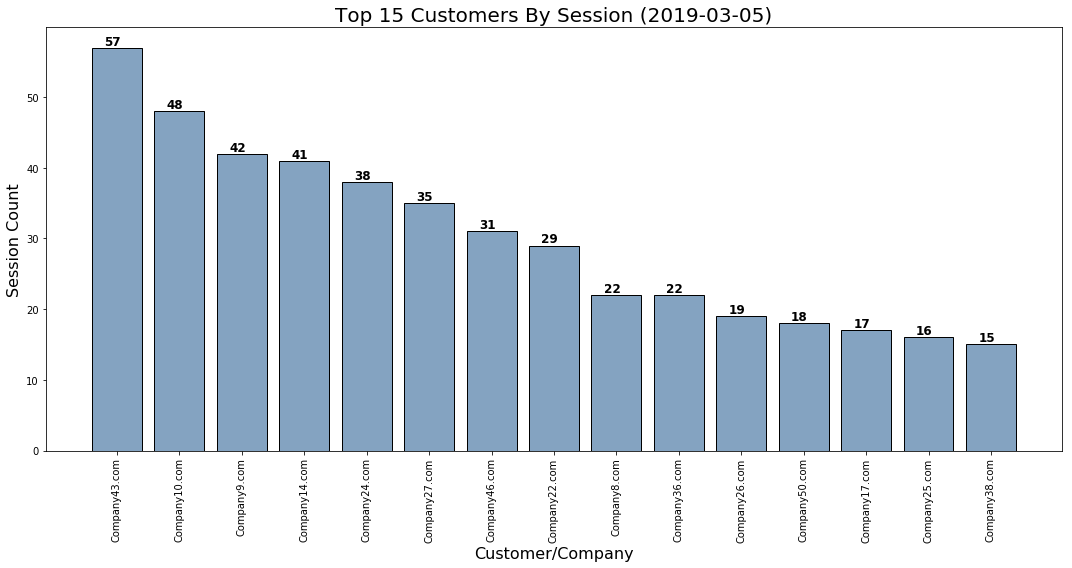

In [70]:
plt.figure(figsize=(15,8))

x_pos = np.arange(len(company_bysession_df["Domain"]))
y_pos = company_bysession_df["SessionCount"]

plt.bar(x_pos, y_pos, color=(0.2, 0.4, 0.6, 0.6), edgecolor = 'black' )
plt.xticks(x_pos, company_bysession_df["Domain"], rotation='vertical', fontsize=10)

# Setting value label for each bar
for i, v in enumerate(y_pos):
    plt.text(i-.20, v+.40, v, color='black', fontweight="bold", fontsize=12)
    
# Setting title, grid and X and Y axis labels
plt.xlabel("Customer/Company", fontsize=16)
plt.ylabel("Session Count", fontsize=16)
plt.title(f'Top 15 Customers By Session ({datetime.now().date()})', fontsize=20)

# Save Figure
plt.tight_layout()
plt.savefig("imgs/Top15CustomerBySession.png",bbox_inches='tight')
plt.show()

#### Notes:
* 15 most active customers out of 47 customers, the session count are between 15 to 57

### Most Active Customers by session count, and average session time

In [71]:
# Average Session Time Per Company
external_customers_df["PageInactiveTime"] = external_customers_df['PageDuration']- external_customers_df['PageActiveDuration']
session_info_df = external_customers_df[['Domain', 'UserEmail', 'UserId', 'PageDuration', 'PageActiveDuration',"PageInactiveTime" , 'PageUrl']]
session_info_df = session_info_df.groupby(["Domain","UserEmail", "UserId"]).head(1).reset_index(drop=True)
session_info_df.sort_values(["Domain","UserEmail", "UserId"], inplace=True)
session_info_df.head()

,Domain,UserEmail,UserId,PageDuration,PageActiveDuration,PageInactiveTime,PageUrl
119,Company1.com,chad.tew@Company1.com,5099875769253888,35621,30044,5577,https://www.cloud.dataguru.com/li/search
0,Company1.com,chad.tew@Company1.com,5650932471693312,20030,3459,16571,https://www.cloud.dataguru.com/li/
54,Company1.com,chad.tew@Company1.com,5745257553592320,52610,43520,9090,https://www.cloud.dataguru.com/li/
221,Company10.com,james.knueven@Company10.com,5070754280374272,4889492,196689,4692803,https://www.cloud.dataguru.com/dataType-UI/?or...
435,Company10.com,james.knueven@Company10.com,5076154207698944,1501676,4867,1496809,https://www.cloud.dataguru.com/dataType-UI/#/d...


In [72]:
# Get average session time per Company in seconds
session_info_df = session_info_df.groupby(["Domain"])
avg_session_info_df = session_info_df['PageDuration','PageActiveDuration',"PageInactiveTime"].mean()
avg_session_info_df = avg_session_info_df.rename(columns={
                       'PageDuration': 'AverageSessionTime (Mins)',
                       'PageActiveDuration': 'AverageActiveSessionTime (Mins)',
                        'PageInactiveTime':'AverageInActiveSessionTime (Mins)'})
avg_session_info_df.head(10)

,AverageSessionTime (Mins),AverageActiveSessionTime (Mins),AverageInActiveSessionTime (Mins)
Domain,,,
Company1.com,3.608700e+04,25674.333333,1.041267e+04
Company10.com,2.291941e+06,177536.083333,2.114405e+06
Company11.com,8.223473e+05,187558.333333,6.347890e+05
Company12.com,3.062218e+06,402044.666667,2.660174e+06
Company13.com,2.090006e+06,45316.666667,2.044690e+06
Company14.com,1.291854e+06,181686.853659,1.110167e+06
Company15.com,6.562460e+05,24982.200000,6.312638e+05
Company16.com,9.093740e+04,37906.200000,5.303120e+04
Company17.com,2.708888e+06,431162.588235,2.277726e+06


In [73]:
# Merge with session count dataframe
company_session_merge_df = pd.merge(company_bysession_df, avg_session_info_df, on="Domain",how ="left")
company_session_merge_df.head(10)

,Domain,SessionCount,AverageSessionTime (Mins),AverageActiveSessionTime (Mins),AverageInActiveSessionTime (Mins)
0,Company43.com,57,7.438626e+06,219182.719298,7.219443e+06
1,Company10.com,48,2.291941e+06,177536.083333,2.114405e+06
2,Company9.com,42,1.168684e+06,218631.404762,9.500529e+05
3,Company14.com,41,1.291854e+06,181686.853659,1.110167e+06
4,Company24.com,38,3.388779e+06,402912.842105,2.985866e+06
5,Company27.com,35,1.571201e+06,207425.514286,1.363775e+06
6,Company46.com,31,9.889472e+05,116545.032258,8.724022e+05
7,Company22.com,29,2.326947e+06,373954.793103,1.952993e+06
8,Company8.com,22,2.226720e+06,415543.727273,1.811176e+06
9,Company36.com,22,1.377183e+06,197441.409091,1.179742e+06


In [74]:
# Use rand method to add weight to columns to find most activate customers

company_session_merge_df["SessionCount_Rank"]= company_session_merge_df["SessionCount"].rank(method='dense')
company_session_merge_df["AverageSessionTime_Rank"]= company_session_merge_df["AverageSessionTime (Mins)"].rank(method='dense')
company_session_merge_df["AverageActiveSessionTime"]= company_session_merge_df["AverageActiveSessionTime (Mins)"].rank(method='dense')
company_session_merge_df["AvgInactive_Rank"] = company_session_merge_df['AverageInActiveSessionTime (Mins)'].rank(method='dense')

weight_Col1=company_session_merge_df["SessionCount_Rank"]
weight_Col2=company_session_merge_df["AverageSessionTime_Rank"]
weight_Col3=company_session_merge_df["AverageActiveSessionTime"]
weight_Col4=company_session_merge_df["AvgInactive_Rank"]

company_session_merge_df["ActiveCustomer_score"]= ((weight_Col1*0.6 + weight_Col2*0.2+
                                                    weight_Col3*0.5 - weight_Col4*0.3)).rank(method='min')

company_session_merge_df.sort_values("ActiveCustomer_score", ascending=False,inplace =True)

customer_rank_df= company_session_merge_df[['Domain', 'SessionCount', 'AverageSessionTime (Mins)',
      'AverageActiveSessionTime (Mins)', 'AverageInActiveSessionTime (Mins)','ActiveCustomer_score']]

# Conver millisecond to minutes
customer_rank_df['AverageSessionTime (Mins)'] = round(customer_rank_df['AverageSessionTime (Mins)']/1000/60 ,2)
customer_rank_df['AverageActiveSessionTime (Mins)'] = round(customer_rank_df['AverageActiveSessionTime (Mins)']/1000/60 ,2)
customer_rank_df['AverageInActiveSessionTime (Mins)'] = round(customer_rank_df['AverageInActiveSessionTime (Mins)']/1000/60 ,2)

customer_rank_df.reset_index(drop=True, inplace=True)

customer_rank_df["customer_Rank"] = customer_rank_df.index
customer_rank_df["customer_Rank"] = customer_rank_df["customer_Rank"].apply(lambda x: x + 1)
 
top_15_customer_rank = customer_rank_df.head(15)
top_15_customer_rank

,Domain,SessionCount,AverageSessionTime (Mins),AverageActiveSessionTime (Mins),AverageInActiveSessionTime (Mins),ActiveCustomer_score,customer_Rank
0,Company43.com,57,123.98,3.65,120.32,15.0,1
1,Company9.com,42,19.48,3.64,15.83,14.0,2
2,Company24.com,38,56.48,6.72,49.76,13.0,3
3,Company14.com,41,21.53,3.03,18.50,12.0,4
4,Company8.com,22,37.11,6.93,30.19,11.0,5
5,Company10.com,48,38.20,2.96,35.24,10.0,6
6,Company22.com,29,38.78,6.23,32.55,9.0,7
7,Company27.com,35,26.19,3.46,22.73,8.0,8
8,Company17.com,17,45.15,7.19,37.96,7.0,9
9,Company36.com,22,22.95,3.29,19.66,6.0,10


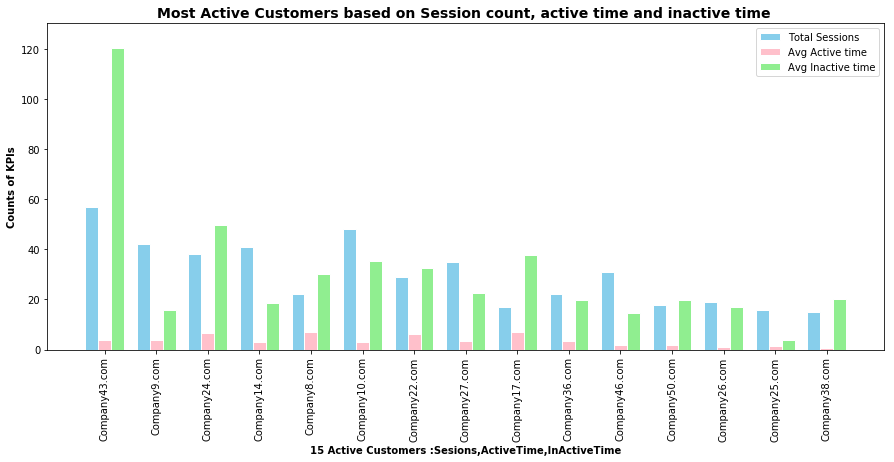

In [75]:
# Ploting the graph
plt.figure(figsize= (15,6))

sessionCount = top_15_customer_rank["SessionCount"]
avg_active = top_15_customer_rank["AverageActiveSessionTime (Mins)"]
avg_inactive = top_15_customer_rank["AverageInActiveSessionTime (Mins)"]
companies  = top_15_customer_rank["Domain"]

# set width of bar
barWidth = 0.25

# Set position of bar on X axis
r1 = np.arange(len(sessionCount))
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]

# Make the plot
plt.bar(r1, sessionCount, color='skyblue', width=barWidth, edgecolor='white', label='Total Sessions')
plt.bar(r2,avg_active, color='pink', width=barWidth, edgecolor='white', label='Avg Active time')
plt.bar(r3, avg_inactive, color='lightgreen', width=barWidth, edgecolor='white', label='Avg Inactive time')

# Add xticks on the middle of the group bars
plt.xlabel('15 Active Customers :Sesions,ActiveTime,InActiveTime', fontweight='bold')
plt.ylabel('Counts of KPIs',fontweight='bold')
plt.xticks([r + barWidth for r in range(len(sessionCount))], companies,rotation='vertical')
plt.title("Most Active Customers based on Session count, active time and inactive time ", fontsize =14, fontweight='bold')

ymax = avg_inactive.max()
plt.ylim(0, ymax+10)
plt.legend()

# Save Figure
plt.savefig("imgs/Top15CustomerByKPIS.png",bbox_inches='tight')
plt.show()

#### Findings
* Companies which have more inactive time also have more session counts
* Avg Active time among companies have less variations

### Top Used Services Overall

In [76]:
# Setting data for most used services
most_used_services_df = external_customers_df.groupby(["serviceName"])["PageUrl"].count()
most_used_services_df = most_used_services_df.reset_index(['serviceName'])
most_used_services_df.rename(columns={"PageUrl": "PageUrlCount"}, inplace=True)
most_used_services_df

,serviceName,PageUrlCount
0,Data Logging,4377
1,Data Package,61864
2,SDK,12050


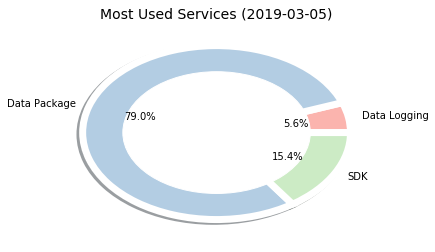

In [77]:
# Plotting the graph
my_circle = plt.Circle( (0,0), 0.7, color='white')
url_count = most_used_services_df["PageUrlCount"]
services = most_used_services_df["serviceName"]
plt.pie(url_count, labels=services, wedgeprops={'linewidth': 7, 'edgecolor': 'white'}, colors=Pastel1_7.hex_colors, autopct="%1.1f%%", shadow=True)
p = plt.gcf()
p.gca().add_artist(my_circle)

plt.title(f'Most Used Services ({datetime.now().date()})', fontsize=14)

# Save Figure
plt.savefig("imgs/MostUsedServices.png",bbox_inches='tight')
plt.show()

#### Findings:
* Data Storage is the mose popular services, 79%
* Data Logging is the least used service, less than 6%

### Most Popular Service among Active Customers

In [78]:
# Get Most Popuylar Service among our Active Customers
company_byservice_df = external_customers_df.groupby(["Domain", "serviceName"])["PageUrl"].count()
company_byservice_df = company_byservice_df.reset_index()
company_byservice_df = company_byservice_df.rename(columns={"PageUrl": "PageCount"})

DomainList= top_15_customer_rank.Domain   
company_byservice_df = company_byservice_df[company_byservice_df.Domain.isin(DomainList)]

company_byservice_df.head(20)

,Domain,serviceName,PageCount
1,Company10.com,Data Package,4395
2,Company10.com,SDK,188
7,Company14.com,Data Package,3611
8,Company14.com,SDK,34
12,Company17.com,Data Package,4400
13,Company17.com,SDK,459
24,Company22.com,Data Package,5539
25,Company22.com,SDK,2094
28,Company24.com,Data Logging,149
29,Company24.com,Data Package,9487


In [79]:
# Setting data in pivot for graphs
pivot_df = company_byservice_df.pivot(index ="Domain",columns = "serviceName",values = "PageCount")
pivot_df.fillna(0, inplace=True)
pivot_df = pivot_df.sort_values(by=['Data Package'], ascending=False)
pivot_df

serviceName,Data Logging,Data Package,SDK
Domain,,,
Company24.com,149.0,9487.0,1766.0
Company22.com,0.0,5539.0,2094.0
Company43.com,0.0,5421.0,977.0
Company9.com,0.0,5214.0,2906.0
Company8.com,123.0,4420.0,16.0
Company17.com,0.0,4400.0,459.0
Company10.com,0.0,4395.0,188.0
Company14.com,0.0,3611.0,34.0
Company36.com,24.0,2682.0,274.0


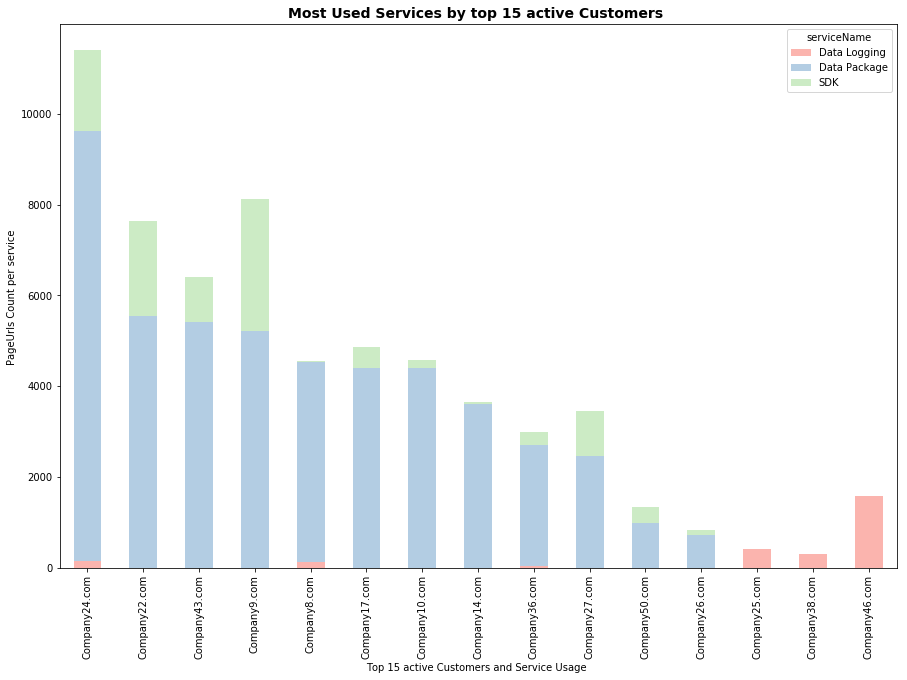

In [80]:
# Creating stacked graph
pivot_df.plot.bar(stacked=True, colors=Pastel1_7.hex_colors, figsize=(15,10))
plt.xlabel("Top 15 active Customers and Service Usage ")
plt.ylabel("PageUrls Count per service ")
plt.title("Most Used Services by top 15 active Customers ",fontsize =14, fontweight='bold')
plt.ylim(0,pivot_df["Data Package"].max()+2500)

# Save Figure
plt.savefig("imgs/Top15Customer_ServiceUsage.png",bbox_inches='tight')
plt.show()

#### Findings:
* Data Package is the most popular services
* Data Logging is the least used packages, only about 30% customer use this services

### Browsers used by customers

In [81]:
Popular_Browser_df = external_customers_df["PageBrowser"].unique()  
Popular_Browser_df = external_customers_df.groupby(["PageBrowser"])["Domain"].count()
Popular_Browser_df = Popular_Browser_df.sort_values(ascending=False)
Popular_Browser_df = Popular_Browser_df.reset_index()
Popular_Browser_df.rename(columns={"Domain": "UserCount"}, inplace=True)
Popular_Browser_df

,PageBrowser,UserCount
0,Chrome,71304
1,Firefox,3385
2,Safari,2993
3,Microsoft Edge,531
4,Internet Explorer,78


In [82]:
def func(pct, allvals):
    absolute = int(pct/100.*np.sum(allvals))    
    return "{:.1f}%".format(pct, absolute)

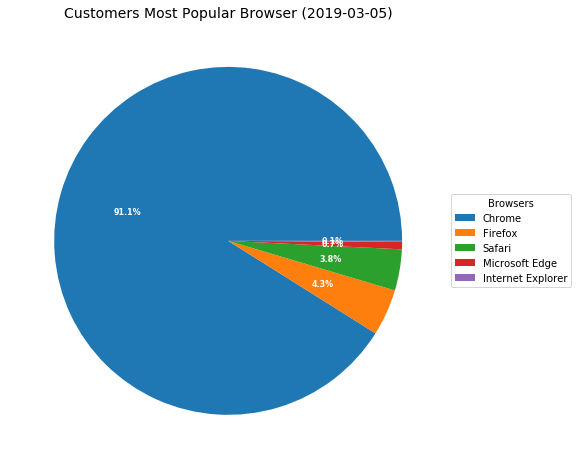

In [83]:
# Plot the graph
fig, ax = plt.subplots(figsize=(10, 8), subplot_kw=dict(aspect="equal"))
wedges, texts, autotexts = ax.pie(Popular_Browser_df["UserCount"], autopct=lambda pct: func(pct, Popular_Browser_df["UserCount"]),
                                  textprops=dict(color="w"))

ax.legend(wedges, Popular_Browser_df["PageBrowser"],
          title="Browsers",
          loc="center left",
          bbox_to_anchor=(1, 0, 0.5, 1))
plt.setp(autotexts, size=8, weight="bold")
plt.title(f'Customers Most Popular Browser ({datetime.now().date()})', fontsize=14)

# Save figure
plt.savefig("imgs/MostPopularBrowserPie.png",bbox_inches='tight')
plt.show()

#### Findings:
* Chrome is the most popular browser - 91%
* Microsoft Edge and Internet Explore together is less than 4%

### Most Popular Devices used by our customers 

In [84]:
Popular_Device_df = external_customers_df.groupby(["PageDevice"])["Domain"].count()
Popular_Device_df = Popular_Device_df.sort_values(ascending=False)
Popular_Device_df = Popular_Device_df.reset_index()
Popular_Device_df = Popular_Device_df.rename(columns={"Domain": "UserCount"})
Popular_Device_df

,PageDevice,UserCount
0,Desktop,78217
1,Mobile,49
2,Tablet,25


#### Observation -  This is quite obvious that most of the users are using Desktop to use our servcies .

### Page Analysis

In [85]:
page_counts_df = external_customers_df.groupby(["PageUrl_Norm"])["PageUrl"].count().sort_values(ascending=False)
page_counts_df = pd.DataFrame(page_counts_df).rename(columns={"PageUrl": "PageCount"})
top_10_urls = page_counts_df.head(10)
top_10_urls.reset_index(inplace = True)
top_10_urls

,PageUrl_Norm,PageCount
0,dataType-UI/#/blueprint-ui;ash=/blueprint,13494
1,dataType-UI/#/data-provision-ui;ash=/endpoints,4725
2,dataType-UI/#/dataType-ui;ash=/dataType,3686
3,dataType-UI/#/data-provision-ui;ash=/networkPr...,3581
4,dataType-UI/#/data-provision-ui;ash=/cloudZones,3486
5,dataType-UI/#/data-provision-ui;ash=/projects,3201
6,dataType-UI/#/data-provision-ui;ash=/quickstart,3108
7,dataType-UI/#/blueprint-ui;ash=/blueprints,2904
8,catalog/#/administration/contentSources,2689
9,catalog/#/administration/content,2466


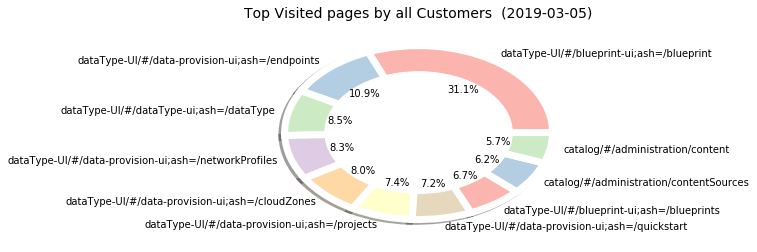

In [86]:
# Plotting the graph
my_circle = plt.Circle( (0,0), 0.7, color='white')
plt.pie(top_10_urls["PageCount"], labels=top_10_urls["PageUrl_Norm"], wedgeprops = { 'linewidth' : 7, 'edgecolor' : 'white' }, colors=Pastel1_7.hex_colors, autopct="%1.1f%%", shadow=True)
p = plt.gcf()
p.gca().add_artist(my_circle)
plt.title(f'Top Visited pages by all Customers  ({datetime.now().date()})', fontsize=14)

# Save Figure
plt.savefig("imgs/TopVisitedPages_Overall.png",bbox_inches='tight')
plt.show()

#### Findings
* "dataType-UI/#/blueprint-ui;ash=/blueprint" is the most visited page - 31%

### Top Visted pages by our top 3 active customers

In [87]:
top3_customer = customer_rank_df.head(3)
domain_list = top3_customer.Domain

# Get top 10 visited pageURLs for each domain in the domain list
customer_pages = external_customers_df.groupby(["Domain", "PageUrl_Norm"]).count()["PageUrl"]
customer_pages = customer_pages.reset_index()
customer_pages.rename(columns = {"PageUrl": "PageCount"}, inplace = True)

comp_dfs = []
max_count = 0

for company in domain_list:
    comp_df = customer_pages[customer_pages["Domain"] == company]
    comp_df = comp_df.sort_values("PageCount",ascending = False).head(10)
    comp_df.sort_values(by="PageCount", inplace = True)
    comp_df.reset_index(drop=True, inplace = True)
    comp_dfs.append(comp_df)

    maxct = comp_df["PageCount"].max()
    max_count = maxct if maxct > max_count else max_count


In [88]:
# Get the company name from the list: comp_dfs
def get_company(comp_df):
    """company name
    
    parameters
    ----------
    comp_df: list
        list of company dataframe
        
    return
    ------
    company: string
        company name
    """
    return comp_df["Domain"].unique()[0].split('.')[0] 

In [89]:
# Function to plot the horizen bar chart for the Top 10 Visted Pages by company
def plot_top10_urls(domain_df):
    """plot the horizen bar chart for the Top 10 Visted Pages by company
    
    parameters
    ----------
    domain_df: dataframe
    """
    
    company = get_company(comp_df)

    plt.tight_layout()
    plt.figure(figsize = (10, 5))

    page_count = comp_df["PageCount"]
    urls = comp_df["PageUrl_Norm"]

    plt.barh(urls, page_count, align='center', alpha=0.5)

    for i, v in enumerate(page_count):
        plt.text(v, i-0.2, str(v), color='blue', fontsize = 11)

    plt.xlabel('Page Visits Count', fontsize = 12)
    plt.ylabel('Page URLs',  fontsize = 12)
    plt.title(f"{company} :: Top 10 Pages Visited", fontsize =13, fontweight='bold')

    # Save Figure
    plt.savefig(f"imgs/Top10VisitedPages_by_{company}.png", bbox_inches='tight')
    plt.show()

<Figure size 432x288 with 0 Axes>

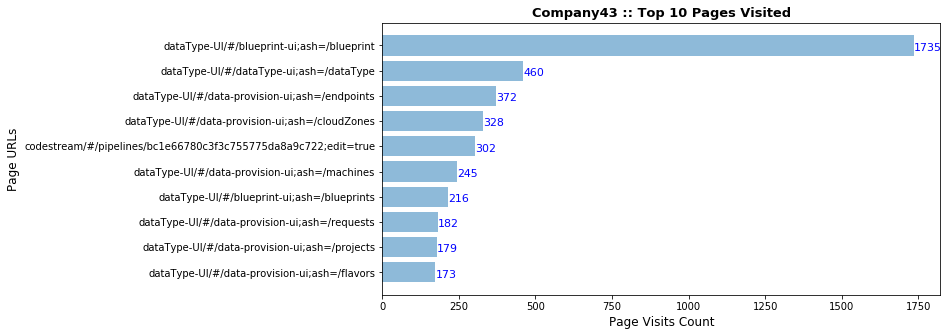

<Figure size 432x288 with 0 Axes>

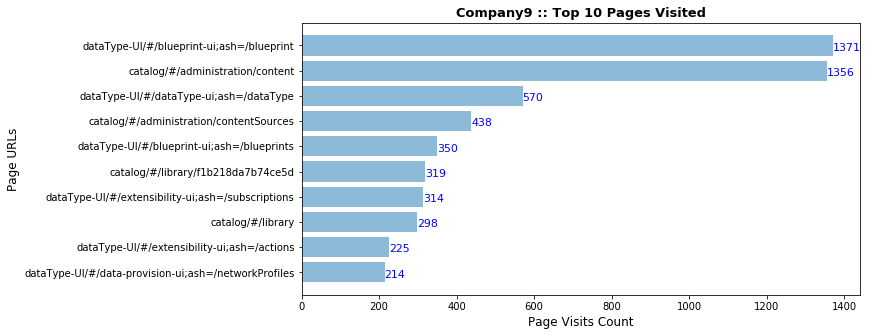

<Figure size 432x288 with 0 Axes>

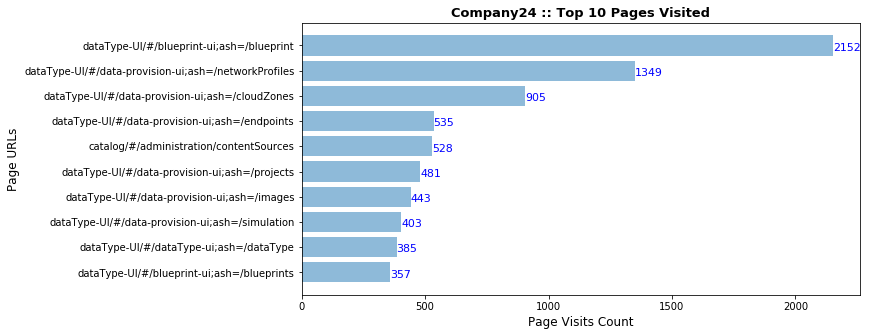

In [90]:
# Plot
counter = 0
for comp_df in comp_dfs:
    comp_df =  comp_df.sort_values(by='PageCount')

    plot_top10_urls(comp_df)

    counter += 1

#### Findings:
* "dataType-UI/#/blueprint-ui;ash=/blueprint" is top visited page foe all top 3 customer 